In [ ]:
%matplotlib inline

In [1]:
from google.colab import drive

drive.mount('/content/drive')
drive.mount("/content/drive", force_remount=True)

Mounted at /content/drive
Mounted at /content/drive


In [2]:
import sys
PROJECT_PATH = '/content/drive/MyDrive/CVMODEL/GradCam/'
sys.path.append(PROJECT_PATH)
import os
#os.chdir(S7_PROJECT_PATH+'/Model/')

In [3]:
import torch
import torchvision
import torchvision.transforms as transforms
import numpy as np

In [4]:
sys.path.append ('/content/drive/MyDrive/CVMODEL/GradCam/TransForm/')
from datatransform import Transforms

common_transforms = Transforms(normalize=False, mean=None, stdev=None)


Data Loading

In [5]:
sys.path.append ('/content/drive/MyDrive/CVMODEL/GradCam/DataLoader/')
from getdata import DataLoader
from torchvision import datasets, transforms
trainset = datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=common_transforms.train_transforms())
# Downloading Testset
testset = datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=common_transforms.test_transforms())




classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [6]:
sys.path.append('/content/drive//MyDrive/CVMODEL/GradCam/Util/')
from Utils import *
mean, std = get_meanstd(trainset, testset)

In [7]:
sys.path.append ('/content/drive/MyDrive/CVMODEL/GradCam/TransForm/Album')
from AlbumMethods import Albumentations as AM
AM().transArguDetails("RandomRotate90", "HorizontalFlip", "ShiftScaleRotate", "GridDistortion", "Normalize")

RandomRotate90 : ArgSpec(args=['self', 'always_apply', 'p'], varargs=None, keywords=None, defaults=(False, 0.5)) ,
HorizontalFlip : ArgSpec(args=['self', 'always_apply', 'p'], varargs=None, keywords=None, defaults=(False, 0.5)) ,
ShiftScaleRotate : ArgSpec(args=['self', 'shift_limit', 'scale_limit', 'rotate_limit', 'interpolation', 'border_mode', 'always_apply', 'p'], varargs=None, keywords=None, defaults=(0.0625, 0.1, 45, 1, 4, False, 0.5)) ,
GridDistortion : ArgSpec(args=['self', 'num_steps', 'distort_limit', 'interpolation', 'border_mode', 'always_apply', 'p'], varargs=None, keywords=None, defaults=(5, 0.3, 1, 4, False, 0.5)) ,
Normalize : ArgSpec(args=['self', 'mean', 'std', 'max_pixel_value', 'always_apply', 'p'], varargs=None, keywords=None, defaults=((0.485, 0.456, 0.406), (0.229, 0.224, 0.225), 255.0, False, 1.0)) ,


In [9]:
train_args= {
#'RandomRotate90' : {},
'HorizontalFlip' : {},
#'Rotate':{-30.0, 30.0},
'ShiftScaleRotate' : {'shift_limit':0.0625, 'scale_limit':0.2, 'rotate_limit':45, 'p':.2},
'GridDistortion' : {'num_steps':5},
'Normalize' : {'mean':mean, 'std':std}
}

test_args={
    'Normalize' : {'mean':mean, 'std':std}
}

train_transforms = AM().transform(**train_args)

# Test Phase transformations
test_transforms = AM().transform(**test_args)

Data Transformation

In [10]:
SEED = 1

#updated_transforms= Transforms(normalize=True, mean=(0.49186878, 0.48265391, 0.44717728), stdev=(0.24697121, 0.24338894, 0.26159259))

# Downloading TrainSet
trainset = datasets.CIFAR10(root='./data', train=True,download=True, transform=train_transforms)

# Downloading Testset
testset = datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=test_transforms)

# Creating object of a class
dataloader= DataLoader(shuffle=True, batch_size=64, seed=SEED, num_workers=2, pin_memory=True)


# train data loader
trainloader = dataloader.load(trainset)

# test data loader
testloader = dataloader.load(testset)

Files already downloaded and verified
Files already downloaded and verified
CUDA Available? True


Check Images

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


 bird plane  bird horse


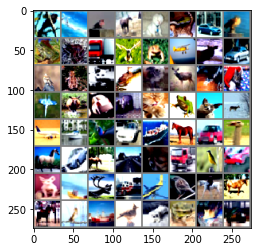

In [11]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))


# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

Define Model

In [24]:
sys.path.append('/content/drive//MyDrive/CVMODEL/GradCam/Model/')

from model import Cfar10Net
from model import Resnet_Architecture
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")

model = Resnet_Architecture(Model_Layers=18).to(device)

summary(model,input_size=(3, 32, 32))


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,728
       BatchNorm2d-2           [-1, 64, 32, 32]             128
            Conv2d-3           [-1, 64, 32, 32]          36,864
       BatchNorm2d-4           [-1, 64, 32, 32]             128
            Conv2d-5           [-1, 64, 32, 32]          36,864
       BatchNorm2d-6           [-1, 64, 32, 32]             128
        BasicBlock-7           [-1, 64, 32, 32]               0
            Conv2d-8           [-1, 64, 32, 32]          36,864
       BatchNorm2d-9           [-1, 64, 32, 32]             128
           Conv2d-10           [-1, 64, 32, 32]          36,864
      BatchNorm2d-11           [-1, 64, 32, 32]             128
       BasicBlock-12           [-1, 64, 32, 32]               0
           Conv2d-13          [-1, 128, 16, 16]          73,728
      BatchNorm2d-14          [-1, 128,

# Model Run

In [33]:

import torch.optim as optim
from torch.optim.lr_scheduler import OneCycleLR
Loss="CrossEntropyLoss"
EPOCHS = 20
model.device=dataloader.device
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
model.gotrain(optimizer=optimizer, train_loader=trainloader, test_loader=testloader, epochs=EPOCHS, statspath=PROJECT_PATH+"Save_Model", scheduler=None, batch_scheduler=False, L1lambda=0, LossType=Loss)


Validation loss decreased (100000.000000 --> 1.106915).  Saving model ...
Epoch: 1, Train set: Average loss: 0.0148, Accuracy: 66.47%; Test set: Average loss: 1.1069, Accuracy: 69.24%



Validation loss decreased (1.106915 --> 0.877071).  Saving model ...
Epoch: 2, Train set: Average loss: 0.0129, Accuracy: 71.04%; Test set: Average loss: 0.8771, Accuracy: 75.65%



Validation loss decreased (0.877071 --> 0.779945).  Saving model ...
Epoch: 3, Train set: Average loss: 0.0116, Accuracy: 74.18%; Test set: Average loss: 0.7799, Accuracy: 78.27%



Validation loss decreased (0.779945 --> 0.715233).  Saving model ...
Epoch: 4, Train set: Average loss: 0.0105, Accuracy: 76.72%; Test set: Average loss: 0.7152, Accuracy: 80.28%



Validation loss decreased (0.715233 --> 0.698966).  Saving model ...
Epoch: 5, Train set: Average loss: 0.0097, Accuracy: 78.48%; Test set: Average loss: 0.6990, Accuracy: 80.87%



Validation loss decreased (0.698966 --> 0.672254).  Saving model ...
Epoch: 6, Train set: Average loss: 0.0091, Accuracy: 79.74%; Test set: Average loss: 0.6723, Accuracy: 80.98%



Validation loss decreased (0.672254 --> 0.596371).  Saving model ...
Epoch: 7, Train set: Average loss: 0.0086, Accuracy: 81.02%; Test set: Average loss: 0.5964, Accuracy: 82.90%



Epoch: 8, Train set: Average loss: 0.0081, Accuracy: 82.02%; Test set: Average loss: 0.6070, Accuracy: 83.34%



Epoch: 9, Train set: Average loss: 0.0076, Accuracy: 83.21%; Test set: Average loss: 0.6268, Accuracy: 82.53%



Epoch: 10, Train set: Average loss: 0.0073, Accuracy: 83.91%; Test set: Average loss: 0.6511, Accuracy: 82.47%



Epoch: 11, Train set: Average loss: 0.0069, Accuracy: 84.98%; Test set: Average loss: 0.6013, Accuracy: 83.31%



Validation loss decreased (0.596371 --> 0.579669).  Saving model ...
Epoch: 12, Train set: Average loss: 0.0066, Accuracy: 85.22%; Test set: Average loss: 0.5797, Accuracy: 84.33%



Validation loss decreased (0.579669 --> 0.499931).  Saving model ...
Epoch: 13, Train set: Average loss: 0.0063, Accuracy: 85.98%; Test set: Average loss: 0.4999, Accuracy: 85.98%



Validation loss decreased (0.499931 --> 0.479980).  Saving model ...
Epoch: 14, Train set: Average loss: 0.0061, Accuracy: 86.47%; Test set: Average loss: 0.4800, Accuracy: 86.65%



Epoch: 15, Train set: Average loss: 0.0058, Accuracy: 87.46%; Test set: Average loss: 0.5640, Accuracy: 85.17%



Epoch: 16, Train set: Average loss: 0.0056, Accuracy: 87.77%; Test set: Average loss: 0.4801, Accuracy: 86.42%



Epoch: 17, Train set: Average loss: 0.0054, Accuracy: 87.96%; Test set: Average loss: 0.5781, Accuracy: 85.45%



Epoch: 18, Train set: Average loss: 0.0053, Accuracy: 88.31%; Test set: Average loss: 0.4914, Accuracy: 86.65%



Validation loss decreased (0.479980 --> 0.467791).  Saving model ...
Epoch: 19, Train set: Average loss: 0.0051, Accuracy: 88.87%; Test set: Average loss: 0.4678, Accuracy: 87.73%



Epoch: 20, Train set: Average loss: 0.0048, Accuracy: 89.36%; Test set: Average loss: 0.5119, Accuracy: 86.97%



3. Define a Loss function and optimizer
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Let's use a Classification Cross-Entropy loss and SGD with momentum.



In [34]:
sys.path.append('/content/drive//MyDrive/CVMODEL/GradCam/Util/')
from Utils import *

In [35]:
class_acurracy(model, model.device, trainloader, classes)

Accuracy of plane : 91 %
Accuracy of   car : 96 %
Accuracy of  bird : 81 %
Accuracy of   cat : 75 %
Accuracy of  deer : 89 %
Accuracy of   dog : 92 %
Accuracy of  frog : 93 %
Accuracy of horse : 92 %
Accuracy of  ship : 95 %
Accuracy of truck : 93 %


# Get Sample of missclassified images

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


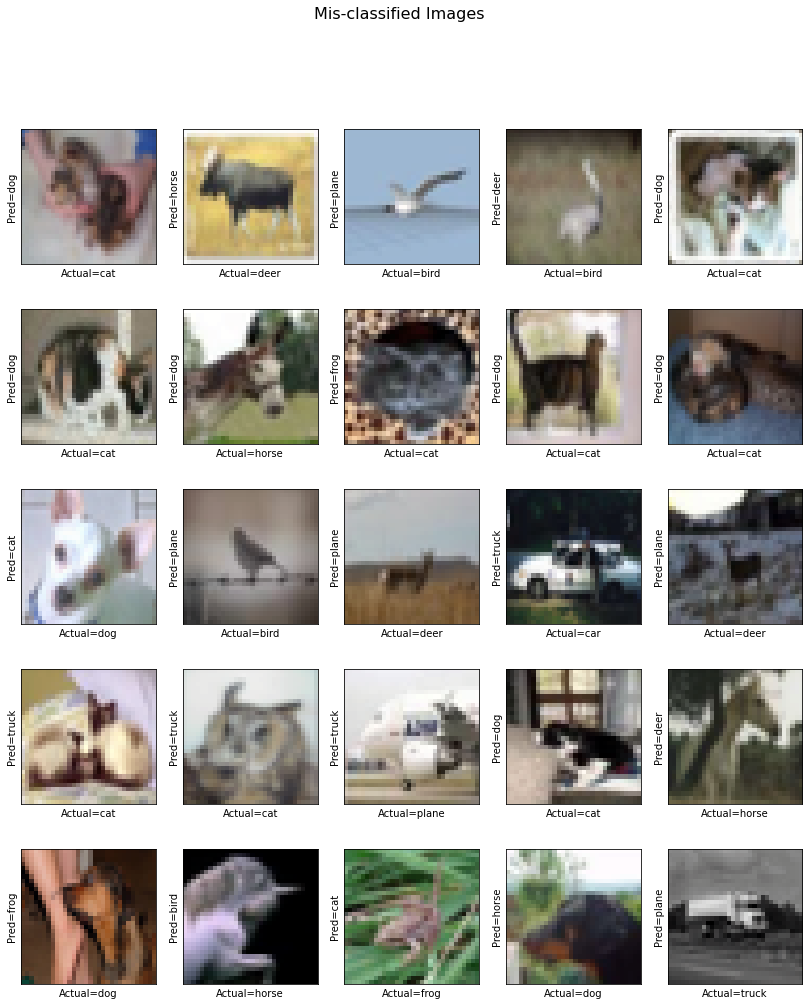

In [36]:
MisClassifiedImages, MisClassifiedPredLabels, MisClassifiedTargLabels = get_classified_images(model, model.device, testloader, classification='Miss')
show_classified(MisClassifiedImages, MisClassifiedPredLabels, MisClassifiedTargLabels, classes, mean, std,"Mis-classified Images",PROJECT_PATH+'/Save_Model/',25)

Get sample of Correct Classified Imgaes

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


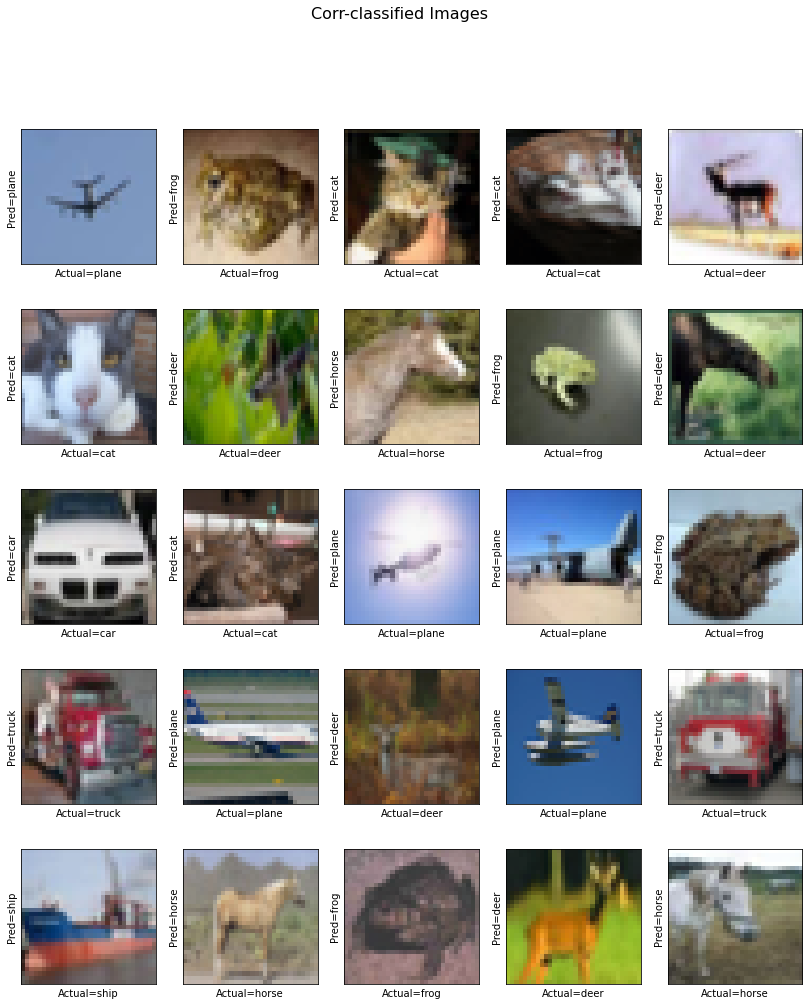

In [37]:

CorrClassifiedImages, CorrClassifiedPredLabels, CorrClassifiedTargLabels = get_classified_images(model, model.device, testloader, classification='Corr')
show_classified(CorrClassifiedImages, CorrClassifiedPredLabels, CorrClassifiedTargLabels, classes, mean, std,"Corr-classified Images",PROJECT_PATH+'/Save_Model/',25)

# getting ResNet Layers

In [38]:
for m,n in model.named_modules():
  print(m,n)

 Resnet_Architecture(
  (resnet_arch): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (shortcut): Sequential()
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=F

In [ ]:
#Gradcam Incorrect Classification

torch.Size([25, 10])
Generating Grad-CAM @resnet_arch.layer1.0
Generating Grad-CAM @resnet_arch.layer2.0
Generating Grad-CAM @resnet_arch.layer3.0
Generating Grad-CAM @resnet_arch.layer4.0


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

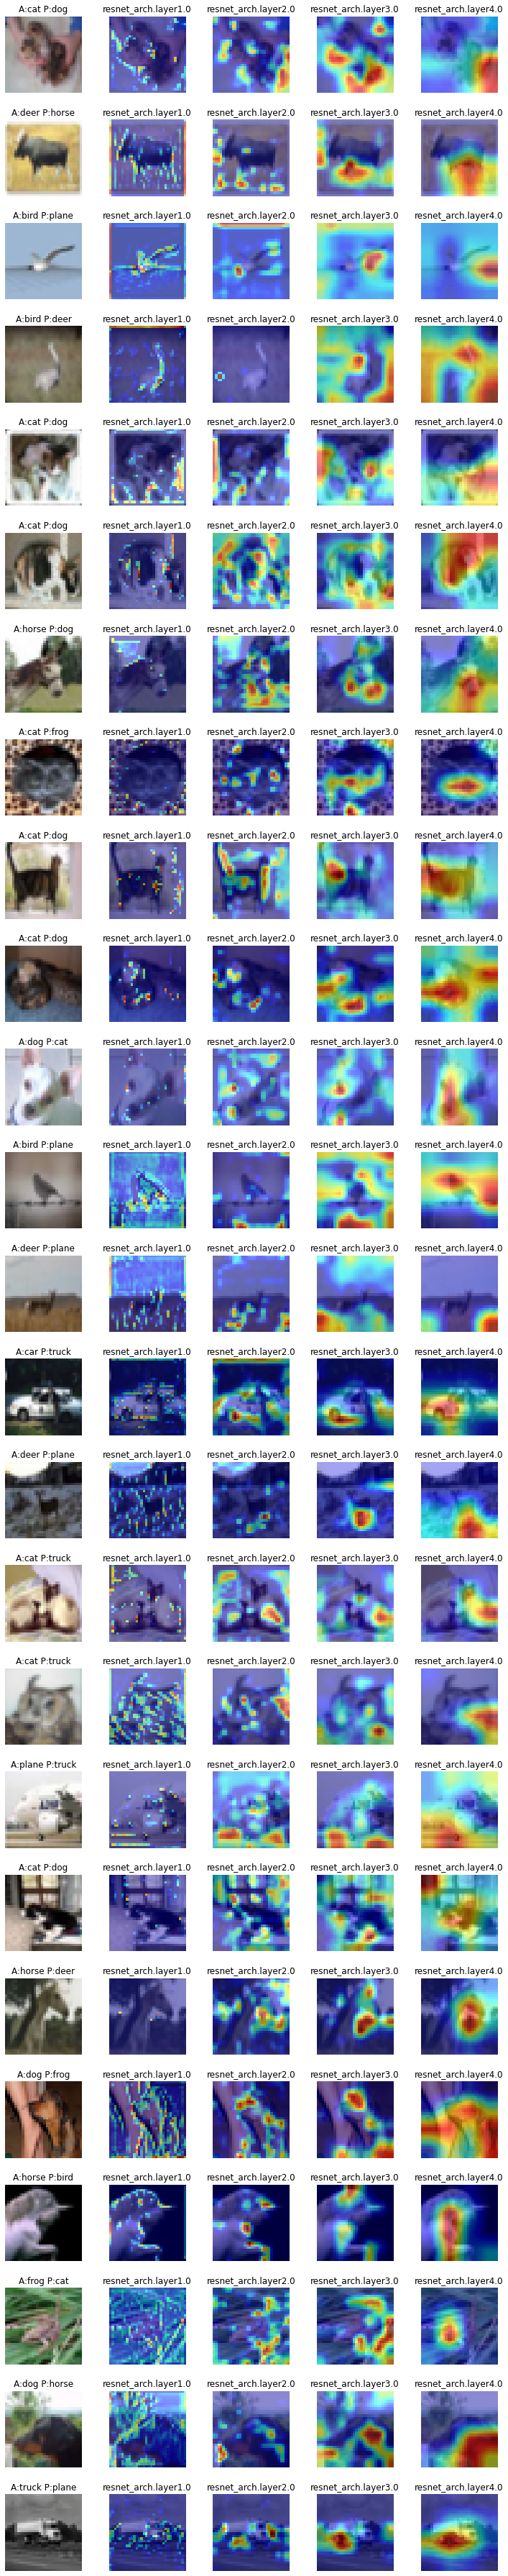

In [39]:
sys.path.append('/content/drive//MyDrive/CVMODEL/GradCam/Gradcam/')
from GradCam import VisualizeCam
target_layers = ["resnet_arch.layer1.0","resnet_arch.layer2.0","resnet_arch.layer3.0","resnet_arch.layer4.0"]
viz_cam = VisualizeCam(model, classes, target_layers)

viz_cam(MisClassifiedImages[:25], MisClassifiedTargLabels[:25], target_layers, mean, std, target_inds=MisClassifiedTargLabels[:25], metric="Incorrect", per_image=False, path=PROJECT_PATH+"/Save_Model/")

GradCam Correct Classification

torch.Size([25, 10])
Generating Grad-CAM @resnet_arch.layer1.0
Generating Grad-CAM @resnet_arch.layer2.0
Generating Grad-CAM @resnet_arch.layer3.0
Generating Grad-CAM @resnet_arch.layer4.0


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


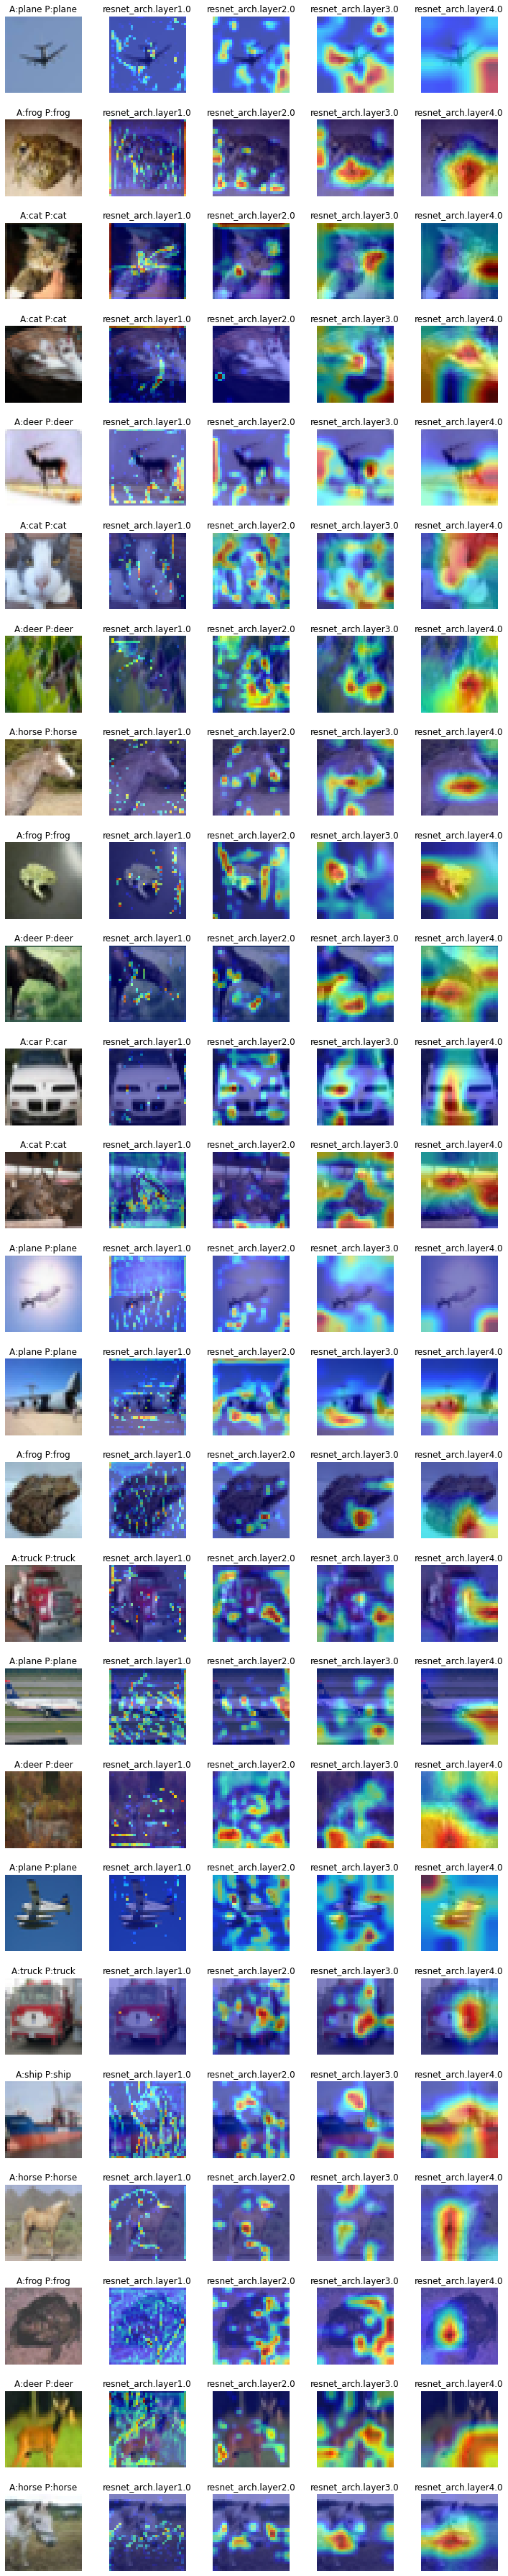

In [41]:
viz_cam(CorrClassifiedImages[:25], CorrClassifiedTargLabels[:25], target_layers, mean, std, target_inds=None, metric="Correct", per_image=False, path=PROJECT_PATH+"/Save_Model/")